In [24]:
import pandas as pd

raw_ds = pd.read_csv("../datasets/base-carboner.csv", low_memory=False)

selected_columns = [
    'Identifiant de l\'élément',
    'Nom base français',
    # 'Localisation géographique',
    'Unité français',
    # 'Incertitude',
    'Total poste non décomposé',
    # 'CH4f', 'CH4b', 'N2O', 'CO2f','CO2b', 'Autres GES', 
]

selected_ds = raw_ds[selected_columns].copy()
selected_ds

,Identifiant de l'élément,Nom base français,Unité français,Total poste non décomposé
0,34052,"""""""\tSalade César au poulet (salade verte""""""",kgCO2e/kg de poids net,2.81
1,40963,"""""""Barre céréalière """"""""équilibre"""""""" aux frui...",kgCO2e/kg de poids net,2.46
2,40964,"""""""Barre céréalière """"""""équilibre"""""""" chocolat...",kgCO2e/kg de poids net,6.09
3,39789,"""""""Bière """"""""coeur de marché"""""""" (4-5° alcool)""""""",kgCO2e/kg de poids net,1.12
4,39790,"""""""Bière """"""""de spécialités"""""""" ou d'abbaye""""""",kgCO2e/kg de poids net,1.12
...,...,...,...,...
18611,26994,yaourtière,kgCO2e/unité,6.15
18612,26994,yaourtière,kgCO2e/unité,3.05
18613,43251,Z-R316c,kgCO2e/kg,5660.00
18614,20535,Zinc,kgCO2e/tonne,2933.00


In [25]:
print(selected_ds['Unité français'].value_counts())

Unité français
kgCO2e/kg de poids net           4302
kgCO2e/kWh                       3750
kgCO2e/kg                        1265
kgCO2e/t.km                       949
kgCO2e/unité                      795
                                 ... 
kg de fluide / m³ de stockage       1
kgDBO                               1
kgCO2e/kg DCO éliminée              1
kgCO2e/kg NTK                       1
kgCO2e/m² de toiture                1
Name: count, Length: 107, dtype: int64


In [26]:
filtered_ds = selected_ds[
    selected_ds['Unité français'] == 'kgCO2e/kg de poids net'
].copy()
filtered_ds.head()

,Identifiant de l'élément,Nom base français,Unité français,Total poste non décomposé
0,34052,"""""""\tSalade César au poulet (salade verte""""""",kgCO2e/kg de poids net,2.81
1,40963,"""""""Barre céréalière """"""""équilibre"""""""" aux frui...",kgCO2e/kg de poids net,2.46
2,40964,"""""""Barre céréalière """"""""équilibre"""""""" chocolat...",kgCO2e/kg de poids net,6.09
3,39789,"""""""Bière """"""""coeur de marché"""""""" (4-5° alcool)""""""",kgCO2e/kg de poids net,1.12
4,39790,"""""""Bière """"""""de spécialités"""""""" ou d'abbaye""""""",kgCO2e/kg de poids net,1.12


In [27]:
min_val = filtered_ds['Total poste non décomposé'].min()
max_val = filtered_ds['Total poste non décomposé'].max()

print(f"Min: {min_val}, Max: {max_val}")


Min: 0.021, Max: 62.7


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
filtered_ds['normalized_emissions'] = scaler.fit_transform(
    filtered_ds[['Total poste non décomposé']]).copy()
filtered_ds.head()

,Identifiant de l'élément,Nom base français,Unité français,Total poste non décomposé,normalized_emissions
0,34052,"""""""\tSalade César au poulet (salade verte""""""",kgCO2e/kg de poids net,2.81,0.044497
1,40963,"""""""Barre céréalière """"""""équilibre"""""""" aux frui...",kgCO2e/kg de poids net,2.46,0.038913
2,40964,"""""""Barre céréalière """"""""équilibre"""""""" chocolat...",kgCO2e/kg de poids net,6.09,0.096827
3,39789,"""""""Bière """"""""coeur de marché"""""""" (4-5° alcool)""""""",kgCO2e/kg de poids net,1.12,0.017534
4,39790,"""""""Bière """"""""de spécialités"""""""" ou d'abbaye""""""",kgCO2e/kg de poids net,1.12,0.017534


In [29]:
import numpy as np
anomaly_df = filtered_ds.copy()
anomaly_df['modifed_emissions']=anomaly_df['normalized_emissions']

 
anomaly_mask = np.random.rand(len(anomaly_df)) < 0.04  # 4% anomalies


anomaly_df['true_anomaly'] = 0
anomaly_df.loc[anomaly_mask, 'true_anomaly'] = 1

for idx in anomaly_df[anomaly_mask].index:
    original = anomaly_df.at[idx, 'normalized_emissions']
    # we check if the emission factor is significant or not to 10x it we also clip all to 2 so max value is always 2.
    if original > 0.05:  
        anomaly_df.at[idx, 'modifed_emissions'] = min(original * 10, 2.0)
        
    else:
        anomaly_df.at[idx, 'modifed_emissions'] = original  
        anomaly_df.at[idx, 'true_anomaly'] = 0  

anomaly_df.head(10)


,Identifiant de l'élément,Nom base français,Unité français,Total poste non décomposé,normalized_emissions,modifed_emissions,true_anomaly
0,34052,"""""""\tSalade César au poulet (salade verte""""""",kgCO2e/kg de poids net,2.81,0.044497,0.044497,0
1,40963,"""""""Barre céréalière """"""""équilibre"""""""" aux frui...",kgCO2e/kg de poids net,2.46,0.038913,0.038913,0
2,40964,"""""""Barre céréalière """"""""équilibre"""""""" chocolat...",kgCO2e/kg de poids net,6.09,0.096827,0.968267,1
3,39789,"""""""Bière """"""""coeur de marché"""""""" (4-5° alcool)""""""",kgCO2e/kg de poids net,1.12,0.017534,0.017534,0
4,39790,"""""""Bière """"""""de spécialités"""""""" ou d'abbaye""""""",kgCO2e/kg de poids net,1.12,0.017534,0.017534,0
5,39791,"""""""Bière """"""""spéciale"""""""" (5-6° alcool)""""""",kgCO2e/kg de poids net,1.12,0.017534,0.017534,0
6,33558,"""""""Brioche fourrée crème pâtissière (type """"""""...",kgCO2e/kg de poids net,3.83,0.060770,0.060770,0
7,41040,"""""""Brioche fourrée crème pâtissière (type """"""""...",kgCO2e/kg de poids net,2.71,0.042901,0.042901,0
8,41052,"""""""Céréales pour petit déjeuner """"""""équilibre""...",kgCO2e/kg de poids net,3.40,0.053910,0.053910,0
9,41053,"""""""Céréales pour petit déjeuner """"""""équilibre""...",kgCO2e/kg de poids net,3.40,0.053910,0.053910,0


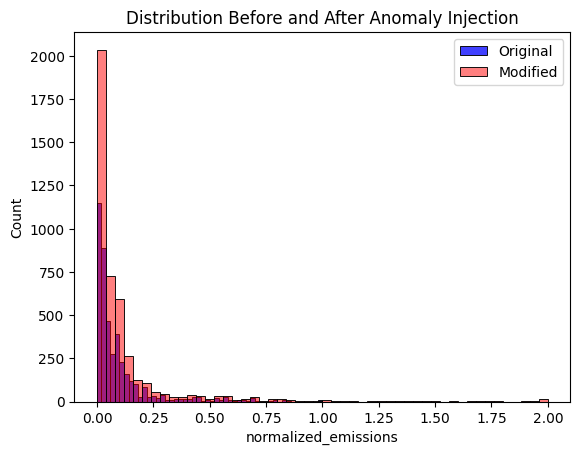

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(anomaly_df['normalized_emissions'], bins=50, label='Original', color='blue')
sns.histplot(anomaly_df['modifed_emissions'], bins=50, label='Modified', color='red', alpha=0.5)
plt.legend()
plt.title("Distribution Before and After Anomaly Injection")
plt.show()


In [31]:
export_ds=anomaly_df[['Identifiant de l\'élément',
'Nom base français','normalized_emissions','modifed_emissions','true_anomaly']]
export_ds.to_csv('../datasets/normalized_sample_emissions_for_anomaly_detection.csv',index=False)